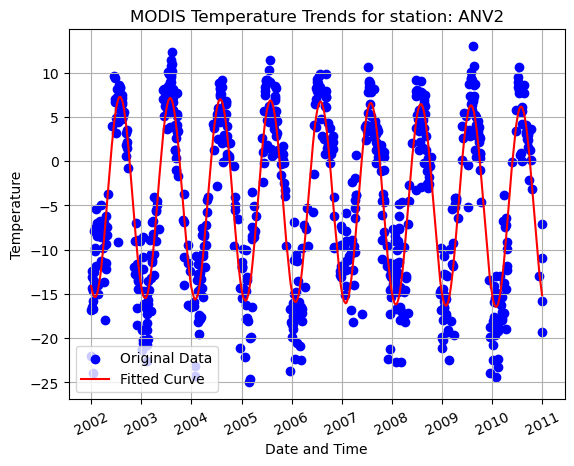

[-4.01056759e+00 -4.39159017e-09 -1.01154595e+01 -5.18410582e+00]
133   -22.03
134   -16.89
135   -12.47
136   -16.47
137   -14.33
       ...  
921   -13.05
923   -19.31
924   -15.83
925    -7.13
926   -11.01
Name: LST_1KM_scaled, Length: 784, dtype: float64


In [3]:
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def analyze_station(station_name):
    file_path = f"E:\\all folders\\STUDIES\\UZH\\master thesis\\MODIS DATA\\Actual Data\\MOD21A1N\\{station_name}.csv"
    df = pd.read_csv(file_path)

    year_column = df.iloc[:, 10]
    month_column = df.iloc[:, 11]
    day_column = df.iloc[:, 12]
    time_column = df.iloc[:, 13]
 
    datetime_column = pd.to_datetime(year_column.astype(str) + '-' + month_column.astype(str) + '-' + day_column.astype(str) + ' ' + time_column)
    temperature_column = df.iloc[:, 2]

    start_date = "2002-01-01"
    end_date = "2010-12-31"
    
    # Filter by date range only
    mask = (datetime_column >= start_date) & (datetime_column < end_date)

    datetime_column = datetime_column[mask]
    temperature_column = temperature_column[mask]

    valid_indices = np.isfinite(temperature_column)
    datetime_column = datetime_column[valid_indices]
    temperature_column = temperature_column[valid_indices]

    # Detect and remove outliers
    z_scores = np.abs((temperature_column - temperature_column.mean()) / temperature_column.std())
    filtered_indices = z_scores < 2  # Adjust threshold as needed
    datetime_column = datetime_column[filtered_indices]
    temperature_column = temperature_column[filtered_indices]

    def harmonic_function(x, b0, b1, b2, b3):
        w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
        return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

    # Convert datetime to seconds since the start date
    time_seconds = (datetime_column - datetime_column.iloc[0]).dt.total_seconds()

    # Fit the harmonic function
    popt, pcov = curve_fit(harmonic_function, time_seconds, temperature_column)

    plt.scatter(datetime_column, temperature_column, color='blue', label='Original Data')
    plt.plot(datetime_column, harmonic_function(np.array(time_seconds), *popt), color='red', label='Fitted Curve')
    plt.xlabel('Date and Time')
    plt.ylabel('Temperature')
    plt.title(f'MODIS Temperature Trends for station: {station_name}')
    plt.legend()
    plt.xticks(rotation=25)
    plt.grid(True)
    plt.show()
    
    return popt, temperature_column, pcov

station_name = "ANV2"
coefficients, temperature_column, pcov = analyze_station(station_name)
print(coefficients)
print(temperature_column)


Results saved to: E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MOD21A1N\Filtered_Data\mean_temperature_trends_by_hour.csv


In [13]:
# Then Code Used to Get the trends hourly
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

def harmonic_function(x, b0, b1, b2, b3):
    w = 2 * np.pi / (365.25 * 24 * 60 * 60)  # Frequency in radians per second
    return b0 + (b1 * x) + (b2 * np.cos(w * x)) + (b3 * np.sin(w * x))

def analyze_station(file_path):
    df = pd.read_csv(file_path)

    # Check if the expected columns are present
    if df.shape[1] < 14:
        print(f"Warning: File {file_path} has fewer than 14 columns.")
        return None, None, None  # Return None for all values

    year_column = df.iloc[:, 10]
    month_column = df.iloc[:, 11]
    day_column = df.iloc[:, 12]
    time_column = df.iloc[:, 13]

    datetime_column = pd.to_datetime(year_column.astype(str) + '-' + month_column.astype(str) + '-' + day_column.astype(str) + ' ' + time_column)
    temperature_column = df.iloc[:, 2]

    # Filter by date range only
    start_date = "2000-01-01"
    end_date = "2023-12-31"
    mask = (datetime_column >= start_date) & (datetime_column < end_date)

    datetime_column = datetime_column[mask]
    temperature_column = temperature_column[mask]

    valid_indices = np.isfinite(temperature_column)
    datetime_column = datetime_column[valid_indices]
    temperature_column = temperature_column[valid_indices]

    # Detect and remove outliers
    z_scores = np.abs((temperature_column - temperature_column.mean()) / temperature_column.std())
    filtered_indices = z_scores < 2  # Adjust threshold as needed
    datetime_column = datetime_column[filtered_indices]
    temperature_column = temperature_column[filtered_indices]

    # Convert datetime to seconds since the start date
    time_seconds = (datetime_column - datetime_column.iloc[0]).dt.total_seconds()

    # Fit the harmonic function
    try:
        popt, _ = curve_fit(harmonic_function, time_seconds, temperature_column)
    except Exception as e:
        print(f"Error fitting curve for {file_path}: {e}")
        return None, None, None  # Return None for all values in case of an error

    # Calculate slope (b1) from fitted parameters
    slope = popt[1]

    # Number of seconds in a year
    seconds_per_year = 365.25 * 24 * 60 * 60

    # Convert slope from temperature per second to temperature per year
    slope_per_year = slope * seconds_per_year

    # Return both the coefficients and datetime column
    return popt, slope_per_year, datetime_column

# Main function to analyze all stations
def analyze_all_stations(path):
    results = []

    # Iterate through each CSV file in the specified directory
    for station_file in os.listdir(path):
        if station_file.endswith('.csv'):
            file_path = os.path.join(path, station_file)
            popt, slope_per_year, datetime_column = analyze_station(file_path)

            if datetime_column is not None:
                # Calculate trends for each hour of the day
                datetime_hours = datetime_column.dt.hour
                # Calculate trend values using popt parameters
                trend_values = harmonic_function((datetime_hours - datetime_hours.min()) * 3600, *popt)
                trend_results = pd.DataFrame({'Hour': datetime_hours, 'Trend': trend_values})

                # Calculate mean trend for each hour
                mean_trend_per_hour = trend_results.groupby('Hour').mean().reset_index()
                mean_trend_per_hour['Station'] = station_file[:-4]  # Exclude the '.csv' extension
                mean_trend_per_hour['SlopePerYear'] = slope_per_year  # Add slope per year to results

                results.append(mean_trend_per_hour)

    # Combine all results into a single DataFrame
    final_results = pd.concat(results, ignore_index=True)

    # Save the results to a CSV file within the same path
    output_file_path = os.path.join(path, 'mean_temperature_trends_by_hour.csv')
    final_results.to_csv(output_file_path, index=False)
    print(f"Results saved to: {output_file_path}")

# Set the path to your station data
station_data_path = "E:\\all folders\\STUDIES\\UZH\\master thesis\\MODIS DATA\\Actual Data\\MYD21A1N\\Filtered_Data"
analyze_all_stations(station_data_path)


Results saved to: E:\all folders\STUDIES\UZH\master thesis\MODIS DATA\Actual Data\MYD21A1N\Filtered_Data\mean_temperature_trends_by_hour.csv
